In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

from utils import *
from learner import *

In [2]:
def lin(ic, oc, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
    layers = nn.Sequential(nn.Linear(in_features=ic, out_features=oc, bias=bias))
    if act: layers.append(act())
    if norm: layers.append(norm(oc))
    return layers

In [3]:
class VAE(nn.Module):
    def __init__(self, ic, hc, lc):
        super().__init__()
        self.encoder = nn.Sequential(lin(ic, hc), lin(hc, hc))
        self.mu, self.lv = lin(hc, lc, act=None), lin(hc, lc, act=None)
        self.decoder = nn.Sequential(lin(lc, hc), lin(hc, hc, act=None), lin(hc, ic, act=None))
    
    def forward(self, x):
        x = self.encoder(x)
        mu, lv = self.mu(x), self.lv(x)
        ep = torch.randn_like(lv)
        z = mu + (0.5*lv).exp() * ep
        return self.decoder(z), mu, lv

In [4]:
INPUT_SIZE = 784
HIDDEN_SIZE = 400
LATENT_SIZE = 200
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 1e-3
loss_fn = nn.BCEWithLogitsLoss()


In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader, test_dataloader, class_names = dataloader(train_dataset, test_dataset, BATCH_SIZE)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reconstructions(model, data, num_samples=10):
    with torch.inference_mode():
        recon_batch, _, _ = model(data.reshape(-1, 784))
        recon_batch = recon_batch.cpu()

    # Plot original images
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(data[i].cpu().view(28, 28).numpy(), cmap='gray')
        plt.title('Original')
        plt.axis('off')

    # Plot reconstructed images
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(recon_batch[i].view(28, 28).numpy(), cmap='gray')
        plt.title('New')
        plt.axis('off')

    plt.show()


In [7]:
def train(model, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader))
    for epoch in trange(epochs):
        model.train()
        train_loss = 0
        for X, _ in train_dataloader:
            X = X.to(device).view(-1, 784)
            X_rec, mu, lv = model(X)
            loss = loss_fn(X_rec, X) + (-0.5 * (1 + lv - mu.pow(2) - lv.exp())).mean()
            train_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}\t Loss: {train_loss / len(train_dataloader.dataset)}")
        schedular.step()

In [8]:
vae = VAE(ic=INPUT_SIZE, hc=HIDDEN_SIZE, lc=LATENT_SIZE).to(device)

In [9]:
data, _ = next(iter(test_dataloader))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	 Loss: 0.020661620423197746
Epoch: 1	 Loss: 0.01832416281104088
Epoch: 2	 Loss: 0.017171531915664673
Epoch: 3	 Loss: 0.016228951513767242
Epoch: 4	 Loss: 0.015391410328447819
Epoch: 5	 Loss: 0.014609788544476032
Epoch: 6	 Loss: 0.013887250795960426
Epoch: 7	 Loss: 0.013202331028878689
Epoch: 8	 Loss: 0.012551343999803066
Epoch: 9	 Loss: 0.011939494870603085


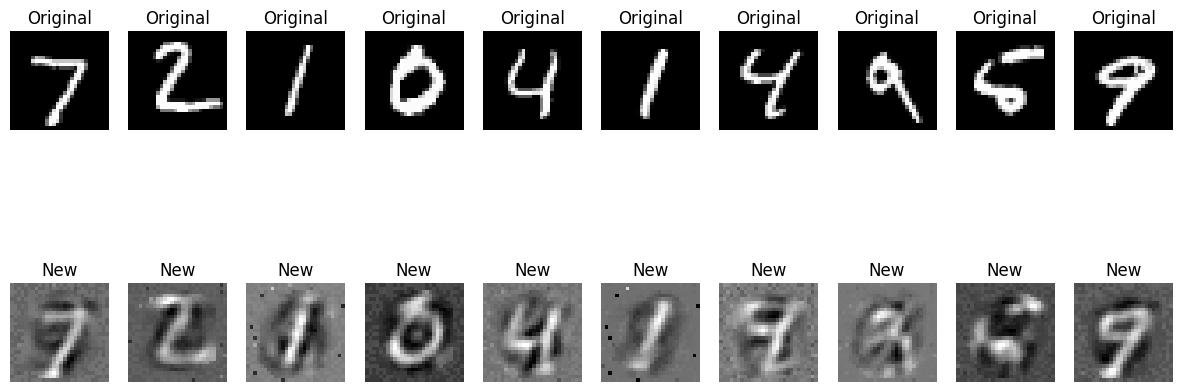

In [10]:
train(vae, 10)
plot_reconstructions(vae, data.to(device))

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0	 Loss: 0.0113443648442626
Epoch: 1	 Loss: 0.010783400386571884
Epoch: 2	 Loss: 0.010266570374369621
Epoch: 3	 Loss: 0.009796121157705784
Epoch: 4	 Loss: 0.009353503584861755
Epoch: 5	 Loss: 0.008950075134634972
Epoch: 6	 Loss: 0.008589671924710274
Epoch: 7	 Loss: 0.008259246125817299
Epoch: 8	 Loss: 0.007964174263179302
Epoch: 9	 Loss: 0.007703265640884638
Epoch: 10	 Loss: 0.007480055093765259
Epoch: 11	 Loss: 0.007279114797711372
Epoch: 12	 Loss: 0.007102286908775568
Epoch: 13	 Loss: 0.0069383918307721615
Epoch: 14	 Loss: 0.006782939657568932
Epoch: 15	 Loss: 0.006645037792623043
Epoch: 16	 Loss: 0.006508805323392153
Epoch: 17	 Loss: 0.0063865287229418755
Epoch: 18	 Loss: 0.006269193720072508
Epoch: 19	 Loss: 0.00616562319919467
Epoch: 20	 Loss: 0.0060681249015033245
Epoch: 21	 Loss: 0.005976193584501743
Epoch: 22	 Loss: 0.005887181498110294
Epoch: 23	 Loss: 0.005803470499813557
Epoch: 24	 Loss: 0.005718214903026819
Epoch: 25	 Loss: 0.00563830928876996
Epoch: 26	 Loss: 0.0055

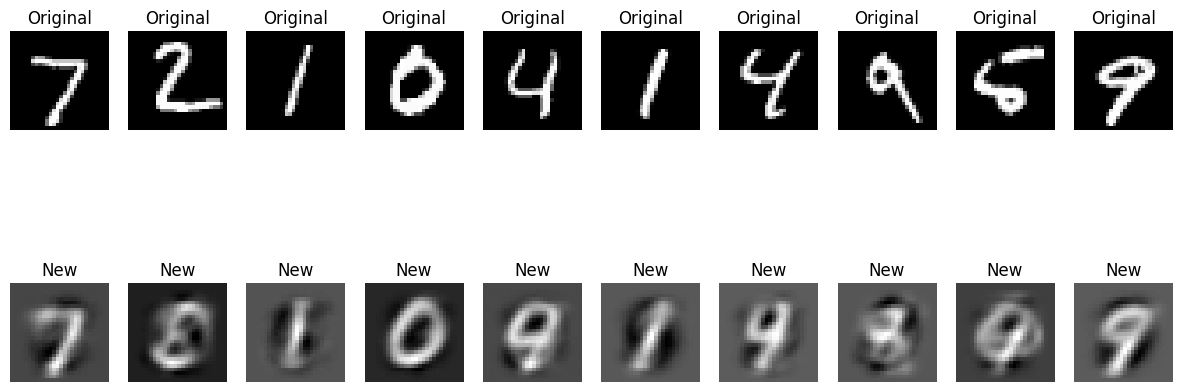

In [11]:
train(vae, 40)
plot_reconstructions(vae, data.to(device))